In [13]:
# Import required libraries
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import matplotlib
from typing import List, Dict, Any

In [14]:
# Load environment variables from .env file
load_dotenv(Path('..').resolve() / '.env')

True

In [15]:
# Add project root to Python path
project_root = Path('..').resolve()
sys.path.append(str(project_root))

In [16]:
# Import project modules
from src.data_processing.db_manager import DatabaseManager
from src.data_processing.data_cleaner import DataCleaner

In [17]:
class EducationAnalysis:
    def __init__(self):
        """Initialize the analysis class"""
        # Set plotting style
        plt.style.use('seaborn-v0_8')  # Use the v0.8 compatible style
        sns.set_theme()  # Use seaborn's default theme
        plt.rcParams['figure.figsize'] = [12, 6]
        plt.rcParams['font.size'] = 12
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
        
        # Initialize database connections and utilities
        self.db_manager = DatabaseManager()
        self.cleaner = DataCleaner()
        
        # Load data
        self.load_data()
    
    def load_data(self):
        """Load data from databases"""
        # Get education investment data
        self.education_data = self.db_manager.query_postgres("""
            SELECT *
            FROM education_data
            ORDER BY year, geo_time_period
        """)
        print(f"Retrieved {len(self.education_data)} education investment records")
        
        # Get economic indicators
        self.economic_data = self.db_manager.query_postgres("""
            SELECT *
            FROM economic_data
            ORDER BY year, country_code
        """)
        print(f"Retrieved {len(self.economic_data)} economic indicator records")
        
        # Try to get policy data
        try:
            if self.db_manager.mongo_db:
                policy_data = self.db_manager.mongo_db['education_policies'].find()
                self.policy_docs = list(policy_data)
                print(f"Retrieved {len(self.policy_docs)} education policy documents")
            else:
                print("Warning: MongoDB connection not available, skipping policy data")
                self.policy_docs = []
        except Exception as e:
            print(f"Error retrieving MongoDB data: {str(e)}")
            self.policy_docs = []
        
        # Display sample of education data
        print("\nSample of education investment data:")
        print(self.education_data.head())
    
    def analyze_investment_trends(self, countries: List[str] = None, start_year: int = 2010):
        """Analyze education investment trends for specified countries"""
        if countries is None:
            # Get top 5 countries by average investment
            countries = (self.education_data.groupby('geo_time_period')['value']
                       .mean()
                       .sort_values(ascending=False)
                       .head(5)
                       .index.tolist())
        
        # Filter data
        mask = (
            (self.education_data['geo_time_period'].isin(countries)) &
            (self.education_data['year'] >= start_year)
        )
        plot_data = self.education_data[mask].copy()
        
        # Create plot
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=plot_data,
            x='year',
            y='value',
            hue='geo_time_period',
            marker='o'
        )
        
        plt.title('Education Investment Trends by Country')
        plt.xlabel('Year')
        plt.ylabel('Investment (PPS)')
        plt.xticks(rotation=45)
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        return plot_data
    
    def analyze_investment_distribution(self, year: int = 2020):
        """Analyze the distribution of education investment across countries"""
        # Filter data for the specified year
        year_data = self.education_data[self.education_data['year'] == year].copy()
        
        # Create box plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=year_data, y='value')
        plt.title(f'Distribution of Education Investment in {year}')
        plt.ylabel('Investment (PPS)')
        plt.show()
        
        # Print summary statistics
        stats = year_data['value'].describe()
        print("\nSummary Statistics:")
        print(stats)
        
        return year_data
    
    def correlation_analysis(self):
        """Analyze correlation between education investment and economic indicators"""
        # Merge education and economic data
        merged_data = pd.merge(
            self.education_data,
            self.economic_data,
            how='inner',
            left_on=['year', 'geo_time_period'],
            right_on=['year', 'country_code']
        )
        
        # Convert columns to numeric, replacing any non-numeric values with NaN
        numeric_columns = ['value', 'gdp_growth', 'employment_rate', 'gdp_per_capita', 'industry_value']
        for col in numeric_columns:
            merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')
        
        # Drop rows with any NaN values
        correlation_data = merged_data[numeric_columns].dropna()
        
        # Rename columns for clarity
        correlation_data = correlation_data.rename(columns={
            'value': 'education_investment'
        })
        
        # Calculate correlations
        corr = correlation_data.corr()
        
        # Create correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation between Education Investment and Economic Indicators')
        plt.tight_layout()
        plt.show()
        
        print("\nCorrelation Matrix:")
        print(corr)
        
        return correlation_data

2024-12-17 10:38:43,497 - INFO - Successfully connected to PostgreSQL


Retrieved 17756 education investment records
Retrieved 378 economic indicator records

Sample of education investment data:
     id freq unit  isced11 geo_time_period  year    value  \
0  1135    A  NAC     ED35              AT  2012  12905.2   
1   208    A  EUR      ED3              AT  2012  11843.4   
2   260    A  EUR  ED34_44              AT  2012  10180.0   
3   934    A  NAC      ED1              AT  2012   8068.6   
4   964    A  NAC    ED1_2              AT  2012   9683.6   

                collected_at    source  
0 2024-12-17 10:35:29.193881  Eurostat  
1 2024-12-17 10:35:29.193881  Eurostat  
2 2024-12-17 10:35:29.193881  Eurostat  
3 2024-12-17 10:35:29.193881  Eurostat  
4 2024-12-17 10:35:29.193881  Eurostat  

Analyzing investment trends...


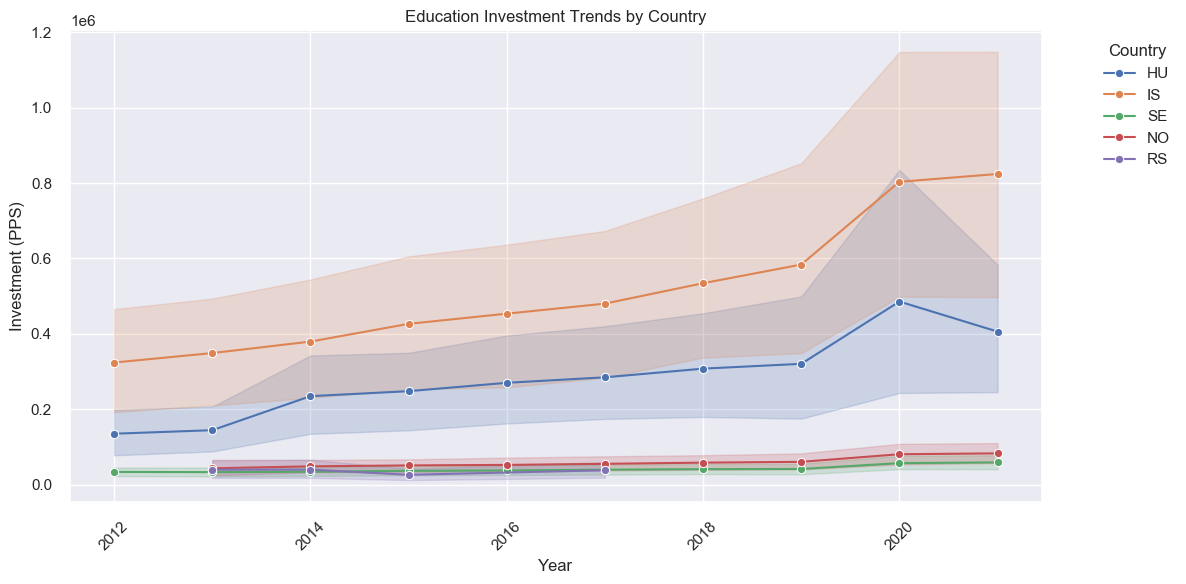


Analyzing investment distribution...


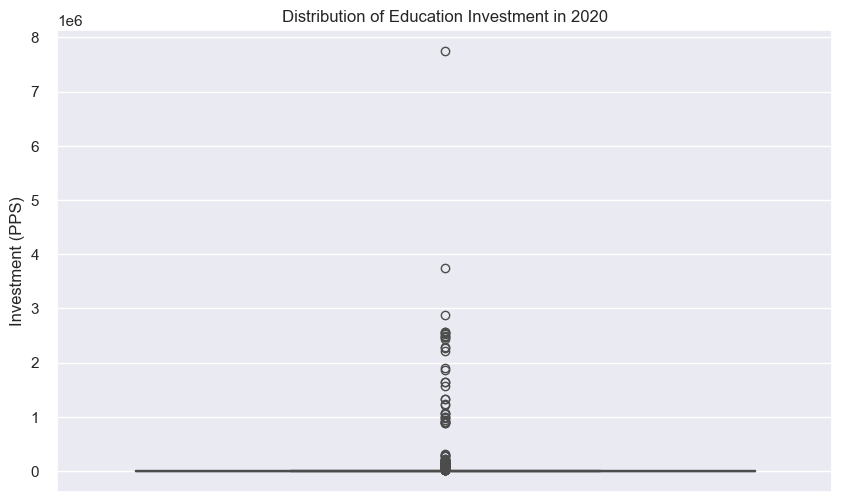


Summary Statistics:
count    1.325000e+03
mean     6.554627e+04
std      3.655998e+05
min      3.309000e+02
25%      5.048500e+03
50%      8.084100e+03
75%      1.231730e+04
max      7.749742e+06
Name: value, dtype: float64

Performing correlation analysis...


/Users/stark/.pyenv/versions/3.11.2/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/stark/.pyenv/versions/3.11.2/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


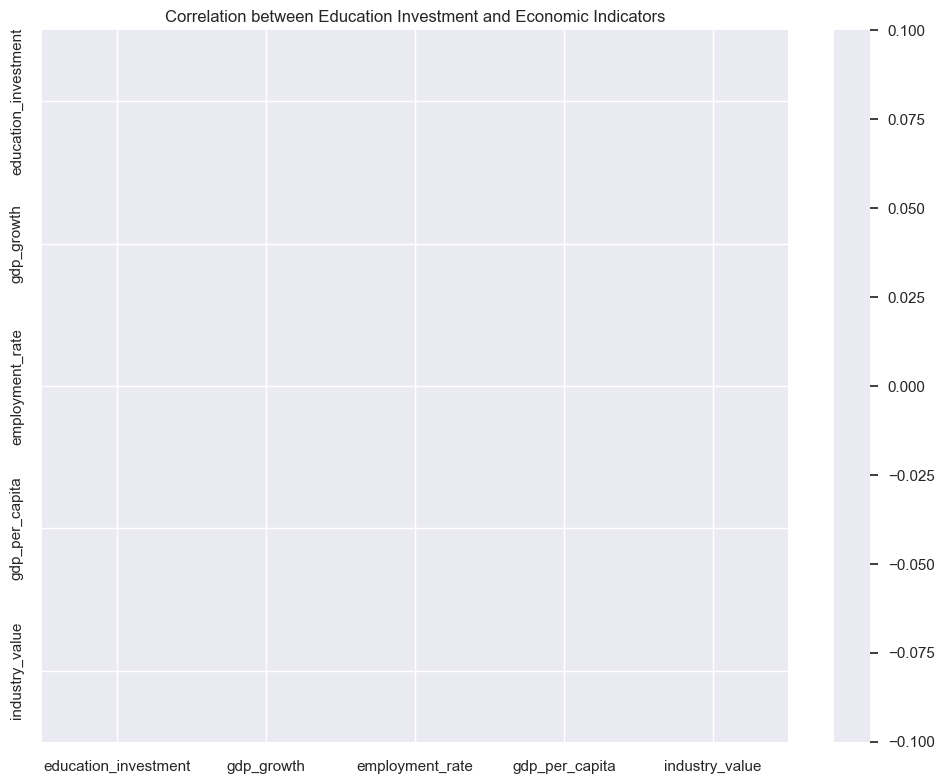


Correlation Matrix:
                      education_investment  gdp_growth  employment_rate  \
education_investment                   NaN         NaN              NaN   
gdp_growth                             NaN         NaN              NaN   
employment_rate                        NaN         NaN              NaN   
gdp_per_capita                         NaN         NaN              NaN   
industry_value                         NaN         NaN              NaN   

                      gdp_per_capita  industry_value  
education_investment             NaN             NaN  
gdp_growth                       NaN             NaN  
employment_rate                  NaN             NaN  
gdp_per_capita                   NaN             NaN  
industry_value                   NaN             NaN  



Correlation Matrix:
                      education_investment  gdp_growth  employment_rate  \
education_investment                   NaN         NaN              NaN   
gdp_growth                             NaN         NaN              NaN   
employment_rate                        NaN         NaN              NaN   
gdp_per_capita                         NaN         NaN              NaN   
industry_value                         NaN         NaN              NaN   

                      gdp_per_capita  industry_value  
education_investment             NaN             NaN  
gdp_growth                       NaN             NaN  
employment_rate                  NaN             NaN  
gdp_per_capita                   NaN             NaN  
industry_value                   NaN             NaN  


In [18]:
# Run analysis
if __name__ == "__main__":
    analysis = EducationAnalysis()
    
    print("\nAnalyzing investment trends...")
    analysis.analyze_investment_trends()
    
    print("\nAnalyzing investment distribution...")
    analysis.analyze_investment_distribution()
    
    print("\nPerforming correlation analysis...")
    analysis.correlation_analysis()